In [52]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from textblob import TextBlob

In [2]:
f = './Phishing_Email.csv'
df = pd.read_csv(f, index_col=0)

In [3]:
df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...
18646,date a lonely housewife always wanted to date ...,Phishing Email
18647,request submitted : access request for anita ....,Safe Email
18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18649,press clippings - letter on californian utilit...,Safe Email


## Data Cleaning

In [4]:
# Get the number of null values in the dataset
df.isnull().sum()

Email Text    16
Email Type     0
dtype: int64

In [5]:
# Drop the na's
clean_df = df.copy()
clean_df.dropna(inplace=True)

In [6]:
# Look for records that contain the text 'empty'
# These records will also be considered missing and dropped as well

len(clean_df.loc[clean_df['Email Text'] == 'empty'])

533

In [7]:
# Select records that do not have the email text 'empty'
clean_df = clean_df[clean_df['Email Text'] != 'empty']

In [8]:
# View the shape after removing nulls
clean_df.shape

(18101, 2)

In [9]:
# Binary Encode the Email Type
clean_df.loc[:, 'Email Type'] =  clean_df['Email Type'].map({'Phishing Email': 1, 'Safe Email': 0})

In [10]:
# Convert to int64
clean_df['Email Type'] = pd.to_numeric(clean_df['Email Type'])
clean_df['Email Type'].dtype

dtype('int64')

In [11]:
# Download stopwords from nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/x/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/x/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Exploratory Data Analysis

In [12]:
eda_df = clean_df.copy()

In [13]:
eda_df.describe()

,Email Type
count,18101.000000
mean,0.385448
std,0.486714
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


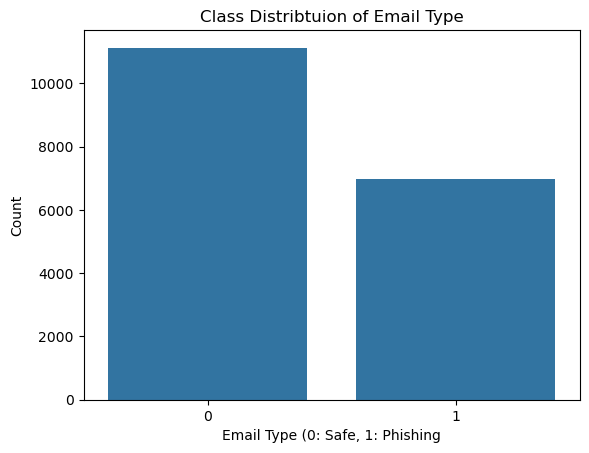

In [14]:
# Create a count plot of the class distribution
sns.countplot(x=eda_df['Email Type'])
plt.title('Class Distribtuion of Email Type')
plt.xlabel('Email Type (0: Safe, 1: Phishing')
plt.ylabel('Count')
plt.show()

In [15]:
# Get the word and character counts for the emails

eda_df['word_count'] = eda_df['Email Text'].apply(lambda x: len(x.split()))
eda_df['char_count'] = eda_df['Email Text'].apply(lambda x: len(x))

In [16]:
eda_df.describe()

,Email Type,word_count,char_count
count,18101.000000,1.810100e+04,1.810100e+04
mean,0.385448,5.509090e+02,2.836649e+03
std,0.486714,2.622834e+04,1.266919e+05
min,0.000000,0.000000e+00,1.000000e+00
25%,0.000000,8.000000e+01,4.340000e+02
50%,0.000000,1.670000e+02,9.130000e+02
75%,1.000000,3.660000e+02,1.936000e+03
max,1.000000,3.527576e+06,1.703669e+07


From the descriptive statistics above, we can see that we have at least one email that contains no characters and at least one that is many magnitudes higher (e+07) than the median (e+02). Let's take a look at the distribution of word_count and char_count.

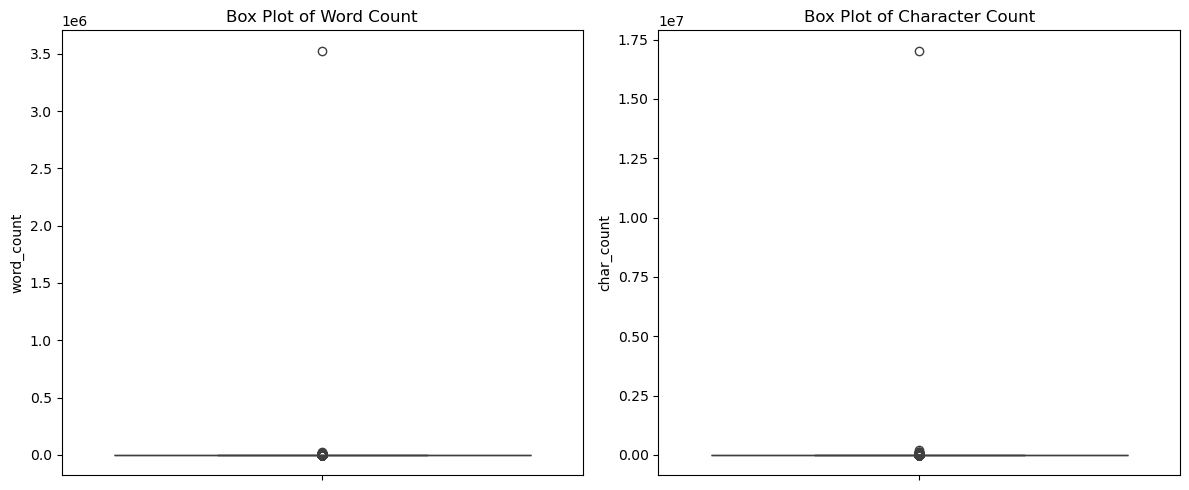

In [17]:
# Review the distributions using box plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot of word_count
sns.boxplot(eda_df['word_count'], ax=axes[0])
axes[0].set_title('Box Plot of Word Count')

# Box plot of char_count
sns.boxplot(eda_df['char_count'], ax=axes[1])
axes[1].set_title('Box Plot of Character Count')

plt.tight_layout()
plt.show()

In [18]:
# Remove the outliers using IQR
q1 = eda_df['char_count'].quantile(0.25)
q3 = eda_df['char_count'].quantile(0.75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the outliers
filtered_df = eda_df[(eda_df['char_count'] >= lower_bound) & (eda_df['char_count'] <= upper_bound)].copy()

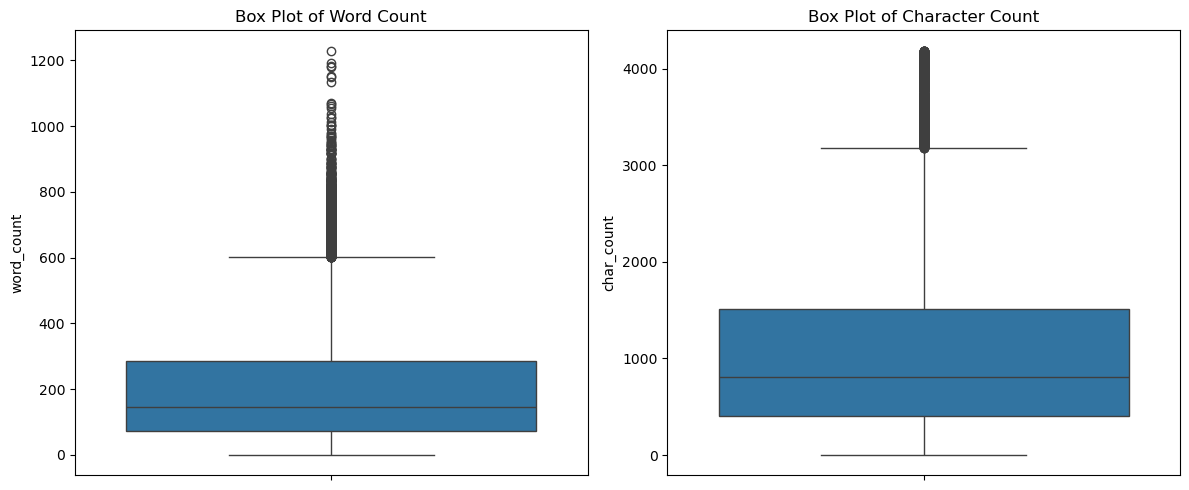

In [19]:
# Review the distributions after removing outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot of word_count
sns.boxplot(filtered_df['word_count'], ax=axes[0])
axes[0].set_title('Box Plot of Word Count')

# Box plot of char_count
sns.boxplot(filtered_df['char_count'], ax=axes[1])
axes[1].set_title('Box Plot of Character Count')

plt.tight_layout()
plt.show()

In [20]:
# Determine the amount of outlier records removed
num_outliers_removed = eda_df.shape[0] - filtered_df.shape[0]

print(f'There were {num_outliers_removed} outlier records removed.')
print(f'The dataset now contains {filtered_df.shape[0]} rows and {filtered_df.shape[1]} columns.')

There were 1662 outlier records removed.
The dataset now contains 16439 rows and 4 columns.


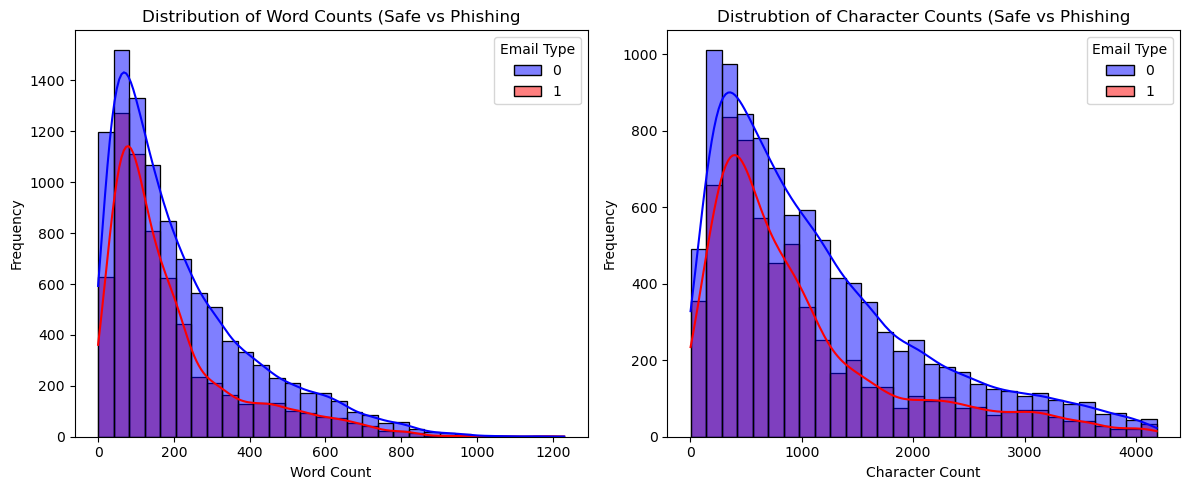

In [21]:
# Check distributions of safe vs phishing emails for word and character counts

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot word count
sns.histplot(data=filtered_df, x='word_count', hue='Email Type', bins=30, kde=True, ax=axes[0], palette={0: 'blue', 1: 'red'})
axes[0].set_title('Distribution of Word Counts (Safe vs Phishing')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Plot character count
sns.histplot(data=filtered_df, x='char_count', hue='Email Type', bins=30, kde=True, ax=axes[1], palette={0: 'blue', 1: 'red'})
axes[1].set_title('Distrubtion of Character Counts (Safe vs Phishing')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Sentiment Analysis

In [22]:
filtered_df['sentiment'] = filtered_df.loc[:,'Email Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

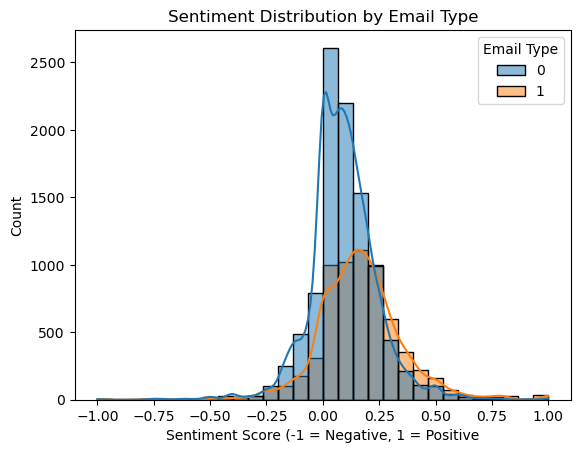

In [23]:
# Plot sentiment distribution
sns.histplot(filtered_df, x='sentiment', hue='Email Type', bins=30, kde=True)
plt.title('Sentiment Distribution by Email Type')
plt.xlabel('Sentiment Score (-1 = Negative, 1 = Positive')
plt.show()

## Most Common Words in Safe vs Phishing Emails

In [24]:
# Split phishing and safe emails
safe_text = ' '.join(filtered_df[filtered_df['Email Type'] == 0]['Email Text'])
phishing_text = ' '.join(filtered_df[filtered_df['Email Type'] == 1]['Email Text'])


## Bag of Words

In [25]:
# Setup the function to clean the text

def bow_preprocess_text(text):
    text = re.sub(r'\W', ' ', text) # Remove special characters
    text = re.sub(r'\d+', ' ', text) # Remove numbers
    text = re.sub(r'\s_', ' ', text).strip() # Remove extra spaces
    text = text.lower()
    words = word_tokenize(text) # Tokenization
    words = [word for word in words if word not in stopwords.words('english')] # Remove stop words
    return ' '.join(words)


In [26]:
model_df = filtered_df.copy()
model_df

,Email Text,Email Type,word_count,char_count,sentiment
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0,230,1030,0.201493
1,the other side of * galicismos * * galicismo *...,0,91,479,0.009375
2,re : equistar deal tickets are you still avail...,0,305,1245,0.091540
3,\nHello I am your hot lil horny toy.\n I am...,1,96,688,0.260069
4,software at incredibly low prices ( 86 % lower...,1,91,441,0.152579
...,...,...,...,...,...
18643,URL: http://diveintomark.org/archives/2002/09/...,0,62,429,0.000000
18646,date a lonely housewife always wanted to date ...,1,45,237,-0.100000
18647,request submitted : access request for anita ....,0,99,477,-0.183333
18648,"re : important - prc mtg hi dorn & john , as y...",0,253,1214,0.141250


In [27]:
# Preprocess text
model_df['Cleaned Text'] = model_df['Email Text'].apply(bow_preprocess_text)

In [28]:
model_df.drop(columns=['Email Text'], inplace=True)

In [29]:
model_df

,Email Type,word_count,char_count,sentiment,Cleaned Text
0,0,230,1030,0.201493,disc uniformitarianism sex lang dick hudson ob...
1,0,91,479,0.009375,side galicismos galicismo spanish term names i...
2,0,305,1245,0.091540,equistar deal tickets still available assist r...
3,1,96,688,0.260069,hello hot lil horny toy one dream open minded ...
4,1,91,441,0.152579,software incredibly low prices lower drapery s...
...,...,...,...,...,...
18643,0,62,429,0.000000,url http diveintomark org archives html plan d...
18646,1,45,237,-0.100000,date lonely housewife always wanted date lonel...
18647,0,99,477,-0.183333,request submitted access request anita dupont ...
18648,0,253,1214,0.141250,important prc mtg hi dorn john discovered rece...


In [30]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(model_df['Cleaned Text'], model_df['Email Type'], test_size=0.2, random_state=42, stratify=model_df['Email Type'])

In [31]:
# Convert to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


## Logistic Regression Model

In [32]:
# Logistic Regression Model
# Create the LR model
lr_model = LogisticRegression()
# Train the LR Model
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evalute model performance
accuracy = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy: {accuracy:.4f}')
print(f'Classification Report: \n{classification_report(y_test, y_pred_lr)}')

Accuracy: 0.9775
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2008
           1       0.98      0.96      0.97      1280

    accuracy                           0.98      3288
   macro avg       0.98      0.97      0.98      3288
weighted avg       0.98      0.98      0.98      3288



In [33]:
feature_names = vectorizer.get_feature_names_out()
top_coefs = lr_model.coef_[0].argsort()[::-1][:20]
print([feature_names[i] for i in top_coefs])

['remove', 'click', 'sightings', 'free', 'money', 'site', 'email', 'save', 'life', 'removed', 'reply', 'hello', 'software', 'offer', 'want', 'viagra', 'best', 'online', 'quality', 'account']


In [34]:
# Confusion Matrix
lr_cm = confusion_matrix(y_test, y_pred_lr)
lr_cm

array([[1982,   26],
       [  48, 1232]])

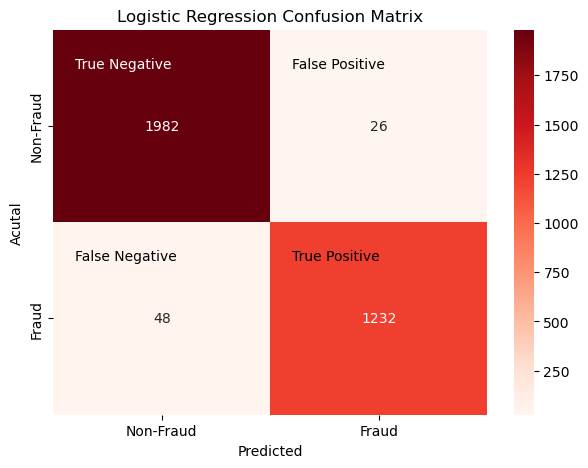

In [66]:
# Plot the LR model confusion matrix
plt.figure(figsize=(7,5))
annotations = [f'TN: {lr_cm[0,0]}', f'FP: {lr_cm[0,1]}'], [f'FN:{lr_cm[1,0]}', f'TP: {lr_cm[1,1]}']
lr_hm = sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])

plt.xlabel('Predicted')
plt.ylabel('Acutal')
plt.title('Logistic Regression Confusion Matrix')
lr_hm.text(0.1, 0.2, 'True Negative', color='white')
lr_hm.text(1.1, 0.2, 'False Positive')
lr_hm.text(0.1, 1.2, 'False Negative')
lr_hm.text(1.1, 1.2, 'True Positive')
plt.show()

In [36]:
# Get the ROC AUC
# Get the probability for the phishing emails
y_probs = lr_model.predict_proba(X_test_tfidf)[:, 1]

roc_auc = roc_auc_score(y_test, y_probs)
roc_auc

0.9973800112051793

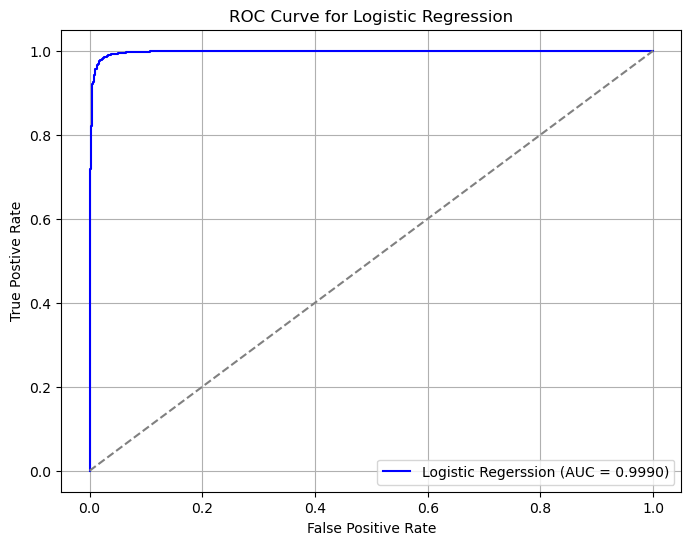

In [54]:
# Plot the ROC curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regerssion (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.grid()
plt.show()

## BERT Model

In [38]:
# Load the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [39]:
# Define tokenize function
def tokenize_function(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')


In [40]:
# Tokenize teh data and convert labels to tensors
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

train_labels = torch.tensor(y_train.tolist())
test_labels = torch.tensor(y_test.tolist())

In [41]:
# Create the Bert Model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Create a TensorDataset for the input_ids and attention masks
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Create data loaders for batch processing
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [43]:
# Use Apple GPU
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [47]:
# Train the BERT model
# Set optimizer
optimizer = AdamW(bert_model.parameters(), lr=3e-5)

epochs = 3

num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

for epoch in range(epochs):
    bert_model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}')
    

Epoch 1, Loss: 229.5264
Epoch 2, Loss: 64.3780
Epoch 3, Loss: 31.5956


In [49]:
# Get the BERT model results
bert_model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Print metrics
print(f'Accuracy: {accuracy_score(true_labels, predictions):.4f}')
print(classification_report(true_labels, predictions))

Accuracy: 0.9857
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2008
           1       0.98      0.98      0.98      1280

    accuracy                           0.99      3288
   macro avg       0.99      0.98      0.98      3288
weighted avg       0.99      0.99      0.99      3288



In [50]:
# BERT Model Confusion Matrix
bert_cm = confusion_matrix(true_labels, predictions)

bert_cm

array([[1986,   22],
       [  25, 1255]])

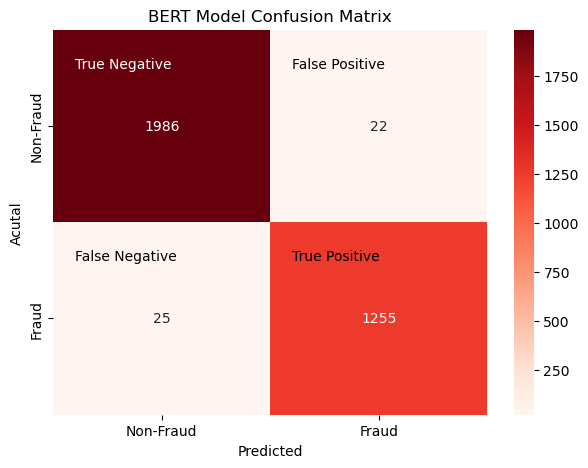

In [63]:
# Plot the BERT model confusion matrix
plt.figure(figsize=(7,5))
annotations = [f'TN: {bert_cm[0,0]}', f'FP: {bert_cm[0,1]}'], [f'FN:{bert_cm[1,0]}', f'TP: {bert_cm[1,1]}']
bert_hm = sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])

plt.xlabel('Predicted')
plt.ylabel('Acutal')
plt.title('BERT Model Confusion Matrix')
bert_hm.text(0.1, 0.2, 'True Negative', color='white')
bert_hm.text(1.1, 0.2, 'False Positive')
bert_hm.text(0.1, 1.2, 'False Negative')
bert_hm.text(1.1, 1.2, 'True Positive')
plt.show()

In [53]:
# Convert logits to probabilities using softmax

with torch.no_grad():
    all_logits = []
    all_true_labels = []
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Probabilities for the positive class
        all_logits.extend(probs)
        all_true_labels.extend(labels.cpu().numpy())

# Compute AUC-ROC Score
roc_auc = roc_auc_score(all_true_labels, all_logits)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9990


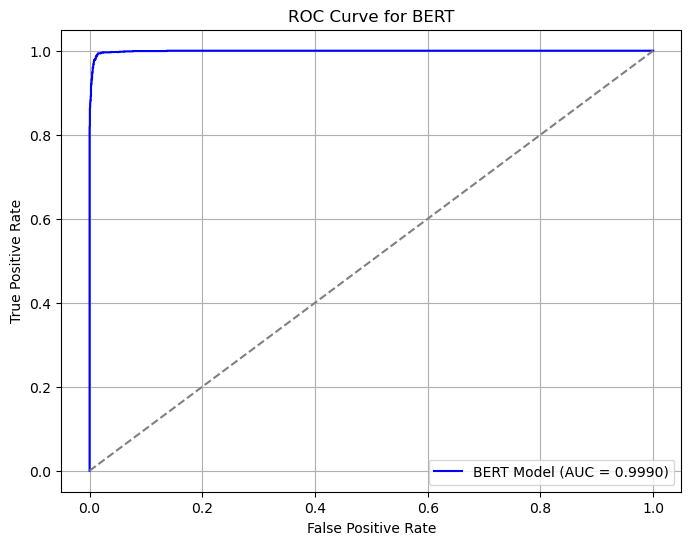

In [57]:
# Plot the ROC curve
bert_fpr, bert_tpr, _ = roc_curve(all_true_labels, all_logits)

plt.figure(figsize=(8,6))
plt.plot(bert_fpr, bert_tpr, label=f'BERT Model (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BERT')
plt.legend()
plt.grid()
plt.show()